# Using the Detailed DHC-A Dataset

The [Detailed Demographic and Housing Characteristic File A (Detailed DHC-A)](https://www.census.gov/programs-surveys/decennial-census/decade/2020/planning-management/release/about-2020-data-products.html#d-dhcfilea)
was released on September 21, 2023. The next day, I put this notebook together to demonstrate how easy it is to load new
datasets with `censusdis`. It is not necessary to fork, modify, or update `censusdis` in any way to handle new data sets. 

It contains, "population counts and sex by age statistics for approximately 1,500 detailed racial and ethnic groups,
such as German, Lebanese, Jamaican, Chinese, Native Hawaiian, and Mexican, as well as American Indian
and Alaska Native (AIAN) tribes and villages like the Navajo Nation."

This notebook demonstrates how to access and analyze this data set with the `censusdis` package. It does the following:

1. Load metadata on DHC-A.
2. Load data on total population of various ractial groups
   for every census tract in the United States.
3. Compute diversity amd integration using this data.
4. Plot the results on maps.

This notebook's code is similar to the code behind the [Diversity and Integration in America](http://di-map.datapinions.com/) interactive map, as described [here](https://datapinions.com/diversity-and-integration-in-america-an-interactive-visualization/). The man difference is that it uses the new DHC-A dataset. 

## Basic imports

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC

import divintseg as dis

In [3]:
import matplotlib.pyplot as plt

## Setup

For more details on what we are setting up here, see the comments 
in this [introductory notebook](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb).


In [4]:
CENSUS_API_KEY = None

In [5]:
YEAR = 2020
DATASET = "dec/ddhca"

What groups are in the dataset?

In [6]:
groups = ced.variables.all_groups(DATASET, YEAR)

groups

,DATASET,YEAR,GROUP,DESCRIPTION
0,dec/ddhca,2020,T01001,TOTAL POPULATION
1,dec/ddhca,2020,T02001,SEX BY AGE (4 AGE CATEGORIES)
2,dec/ddhca,2020,T02002,SEX BY AGE (9 AGE CATEGORIES)
3,dec/ddhca,2020,T02003,SEX BY AGE (23 AGE CATEGORIES)


We will choose the group containing total population, since we are not interested in age at this time.

In [7]:
GROUP = "T01001"

We want data for all states.

In [8]:
states = ALL_STATES_AND_DC

## Fetch metadata

We will fetch the metadata on what fields are available and then select the ones
that represent the population count of people who identify as white, possibly mixed 
with one or more other races and those who identify as white alone.

In [9]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

df_all_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)

df_all_variables

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,dec/ddhca,T01001,T01001_001N,!!Total,NaN,None


## Fetch Data

We add `POPGROUP` so we know what population group each row corresponds to. This is the key field that this data set contains that is new and different compared to how the U.S. Census tracked race and ethnicity in the past. `POPGROUP_LABEL` is a human-readible form of this.

In [10]:
df_tracts = ced.download(
    DATASET,
    YEAR,
    ["POPGROUP", "POPGROUP_LABEL", "T01001_001N"],
    state=states,
    county="*",
    tract="*",
    api_key=CENSUS_API_KEY,
)

In [11]:
df_tracts.head()

,STATE,COUNTY,TRACT,POPGROUP,POPGROUP_LABEL,T01001_001N
0,01,001,020100,1002,European alone,654.0
1,01,001,020100,1024,English alone,356.0
2,01,001,020100,1031,German alone,35.0
3,01,001,020100,1035,Irish alone,91.0
4,01,001,020100,1100,Other White alone,707.0


## Reformat (Pivot) Data

Now, in order to do diversity and integration analysis, we need to reformat the data so that
there is one row per tract and one column in that row for each ethnic group. We can do this using
the `pandas.DataFrame.pivot_table` API.

In [12]:
df_counts = (
    df_tracts.pivot_table("T01001_001N", ["STATE", "COUNTY", "TRACT"], "POPGROUP")
    .reset_index()
    .fillna(0.0)
)

df_counts.head()

POPGROUP,STATE,COUNTY,TRACT,1002,1003,1004,1005,1006,1007,1008,...,4038,4039,4040,4041,4042,4043,4049,4050,4053,4054
0,01,001,020100,654.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,001,020200,404.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01,001,020300,1121.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
3,01,001,020400,1821.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
4,01,001,020501,1794.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0


## Compute Diversity and Integration

See the [divintseg](https://github.com/vengroff/divintseg) project for more details on how these are defined.

In [13]:
df_di = dis.di(
    df_counts,
    by=["STATE", "COUNTY"],
    over="TRACT",
).reset_index()

In [14]:
df_di.head()

,STATE,COUNTY,diversity,integration
0,01,001,0.923593,0.918173
1,01,003,0.916513,0.913558
2,01,005,0.930024,0.920860
3,01,007,0.903660,0.897215
4,01,009,0.894603,0.892896


In [15]:
df_di.describe()

,diversity,integration
count,3143.000000,3143.000000
mean,0.910541,0.904911
std,0.025256,0.023980
min,0.000000,0.000000
25%,0.900181,0.896764
50%,0.909900,0.906272
75%,0.923035,0.915844
max,0.975227,0.963139


In [16]:
df_di.quantile(0.01, numeric_only=True)

diversity      0.858012
integration    0.847259
Name: 0.01, dtype: float64

## Plot the Maps

First we download the geometries of all the counties, then merge it with the diversity and integration data so we can plot the map.

In [17]:
gdf_map = ced.download(
    DATASET,
    YEAR,
    ["NAME"],
    state=states,
    county="*",
    with_geometry=True,
    api_key=CENSUS_API_KEY,
)

In [18]:
gdf_plot = gdf_map.merge(df_di, on=["STATE", "COUNTY"])

In [19]:
gdf_plot.head()

,STATE,COUNTY,NAME,geometry,diversity,integration
0,01,001,"Autauga County, Alabama","POLYGON ((-86.92120 32.65754, -86.92035 32.658...",0.923593,0.918173
1,01,003,"Baldwin County, Alabama","POLYGON ((-88.02858 30.22676, -88.02399 30.230...",0.916513,0.913558
2,01,005,"Barbour County, Alabama","POLYGON ((-85.74803 31.61918, -85.74544 31.618...",0.930024,0.920860
3,01,007,"Bibb County, Alabama","POLYGON ((-87.42194 33.00338, -87.33177 33.005...",0.903660,0.897215
4,01,009,"Blount County, Alabama","POLYGON ((-86.96336 33.85822, -86.95967 33.857...",0.894603,0.892896


We will also get state outlines, just so we can make the map look better.

In [20]:
gdf_states = ced.download(
    DATASET, YEAR, ["NAME"], state=states, with_geometry=True, api_key=CENSUS_API_KEY
)

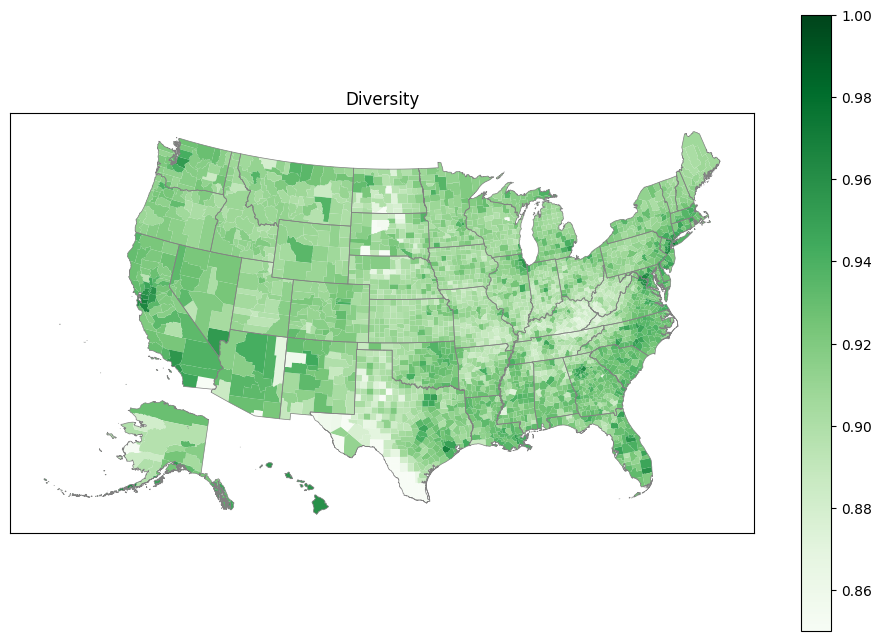

In [21]:
ax = cem.plot_us(
    gdf_plot,
    "diversity",
    legend=True,
    cmap="Greens",
    figsize=(12, 8),
    vmin=0.85,
    vmax=1,
)
ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.5, ax=ax)
_ = ax.set_title("Diversity")

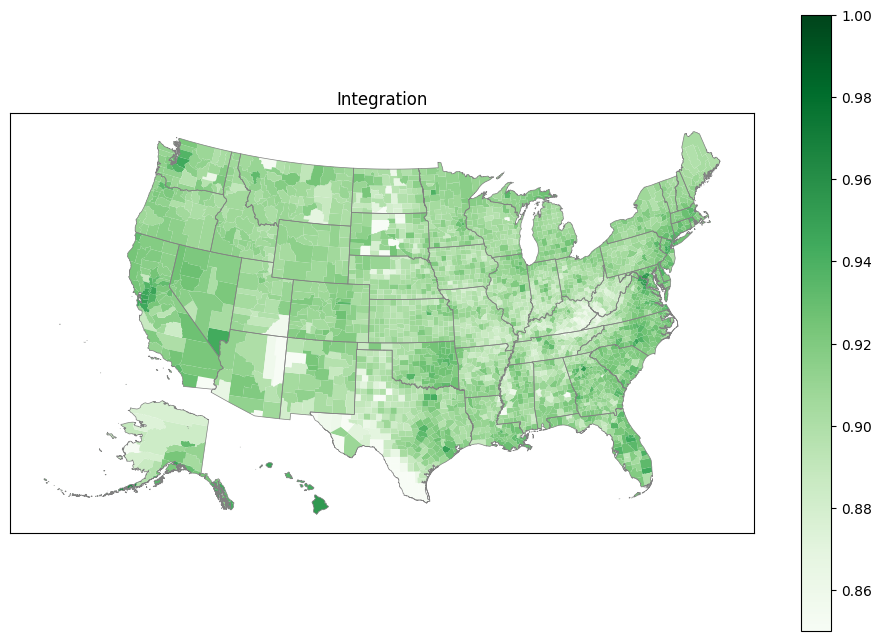

In [22]:
ax = cem.plot_us(
    gdf_plot,
    "integration",
    legend=True,
    cmap="Greens",
    figsize=(12, 8),
    vmin=0.85,
    vmax=1,
)
ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.5, ax=ax)
_ = ax.set_title("Integration")